In [1]:
import numpy as np
import gc
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from pathlib import Path

## Path integration

**Summary**: During this week's course, we learned that the fruitfly *Drosophila* melanogaster, is able to remember the location of a food source in an environement devoid of external stimuli or landmarks. To do so flies integrate their path. To perfrom path integration the fly uses an internal model that converts it's idiothetic (internal) observations to world relevant information. In [A. Behbahani et al.](https://www.sciencedirect.com/science/article/pii/S0960982221011088?via%3Dihub) fly integrate their path using very abstract integrators. 

In this week's exercise we will exploit the embodiement of Neuromechfly to collect random exploration data and explore different idiothetic cues *Drosophila* melanogaster could use to perform path integration.

# Exercise 1: Extract and understand the data

Using the script **exporation.py** we collected all the observations and informations of yielded by Neuromechfly during a random exploration. Using a CPG based controller, flies alternated between forward walking and in-place turning. Turning is modeled as a Poisson process with a rate $\lambda_\text{turn}=1$. The turn duration is drawn from a normal distibution with mean $\mu$ = 0.4 and standart deviation $\sigma$ = 0.1. The directiom of the turn is randomly selected. The turns were performed using an assymetric drive of [-0.2, 1.0] for turns to the left and [1.0, -0.2] for turns to the right. Here is a diagram describing the decision process at every time step.

<p align="center">
    <img src="source/random_exploration.svg" width="1000" height="600" style="background-color: white;"/>
</p>

During this random exploration (typical of a real fly that walks straight and then performs turning saccades) we collected the observation (end effector positions, contact forces, ...) as well as the executed action (adhesion, joint angles). With this dataset we can come up with multiple models and evaluate how they could be used to perform path integration.

If you feel like it have a look at the exploration.py script. It describes how we implemented this controller and collected the data. This script is using the latest API of Neuromechfly. Note that some observations are different than the ones obtained form the base Neuromechfly, I will underly those differences to avoid any confusions.


In [2]:
data_path = Path("data")
trial_paths = sorted(list(data_path.glob("*/*.npz")))
timestep = 1e-3 #The simulations were run with a timestep of 1e-4 but to reduce the data size we resampled it

In [3]:
def load_trial_data(trial_path):
    
    sim_data = np.load(trial_path, allow_pickle=True)

    return {
        "end_effector_pos": sim_data["end_effector_pos"],
        "contact_force": sim_data["contact_force"],
        "dn_drive": sim_data["dn_drive"],
        "fly_orientation": sim_data["fly_orientation"],
        "fly_pos": sim_data["fly_pos"],
        "adhesion": sim_data["adhesion"],
    }

In [4]:
trial_data = []

for trial_path in trial_paths:
    trial_data.append(load_trial_data(trial_path))

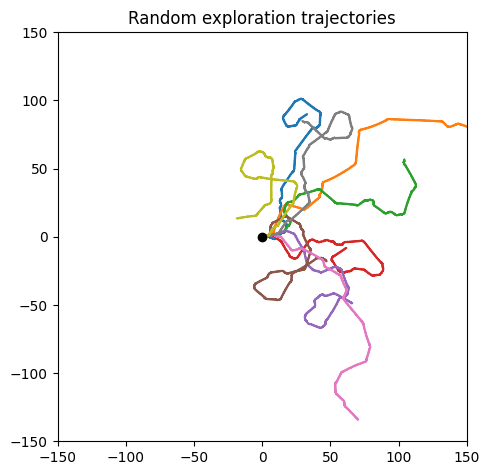

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9), tight_layout=True)
for trial_id in range(len(trial_data)):
    fly_pos = trial_data[trial_id]["fly_pos"]
    ############################
    # TODO: Plot fly trajectories
    ax.plot(fly_pos[:, 0], fly_pos[:, 1], alpha=1)
    ############################
ax.plot([0], [0], "o", color="black")
ax.set_title(f"Random exploration trajectories")
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
ax.set_aspect("equal")

One difference with the base Neuromechfly class is that end effector position is given in fly centric coordinates. Indeed flies do not have access to the position of legs in global coordinates but can use proprioception to get a representation of the position of their end effector in their own coordinate system.  

Here we plot the position of every leg during the longest straight walking bout.

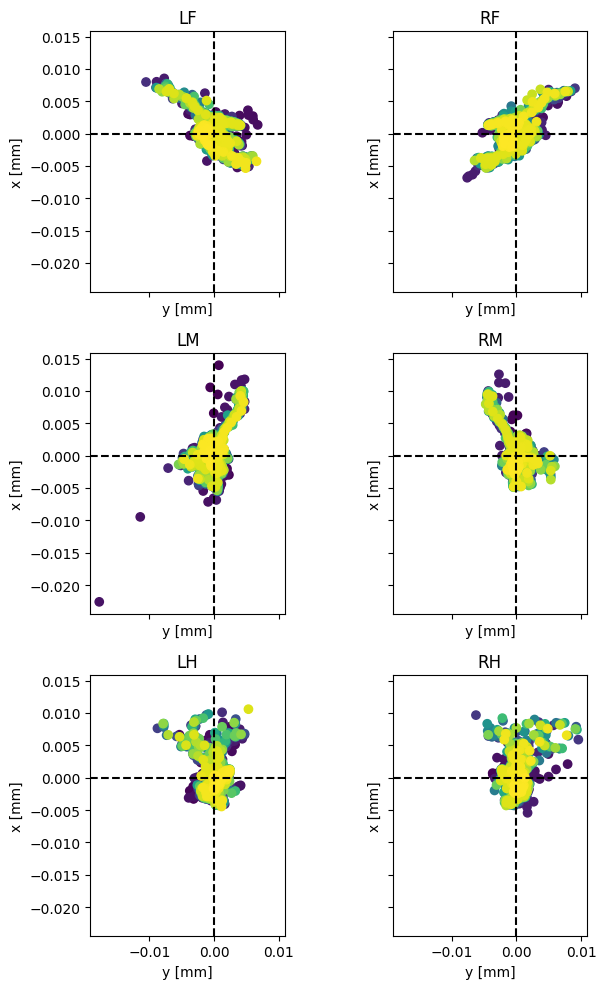

In [6]:
# select the longest period where the fly is walkign straight (no turns)
equal_drive = (np.diff(trial_data[0]["dn_drive"], axis=1) == 0.0).astype(np.int32)
drive_dif = np.diff(equal_drive.squeeze())

straight_start = np.where(drive_dif == 1)[0]
straight_end = np.where(drive_dif == -1)[0]
if straight_end[0] < straight_start[0]:
    straight_end = straight_end[1:]

straight_dur = [se-ss for ss, se in zip(straight_start, straight_end)]
max_straight_id = np.argmax(straight_dur)

start_timestep = straight_start[max_straight_id]
end_timestep = straight_end[max_straight_id]


end_effector_pos = trial_data[0]["end_effector_pos"][start_timestep:end_timestep, :]
time = np.arange(start_timestep, end_timestep)*timestep

leg_map = {"LF": 0, "RF": 1, "LM": 2, "RM": 3, "LH": 4, "RH": 5}
end_effector_order = [side + pos for side in "LR" for pos in "FMH"]

fig , axs = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True, tight_layout=True)
axs = axs.flatten()
for j, leg in enumerate(end_effector_order):
    i = leg_map[leg]
    axs[i].scatter(end_effector_pos[:, j, 1], end_effector_pos[:, j, 0], c=time)    
    axs[i].set_title(leg)
    axs[i].set_xlabel("y [mm]")
    axs[i].set_ylabel("x [mm]")
    axs[i].axvline(0, color="black", linestyle="--")
    axs[i].axhline(0, color="black", linestyle="--")
    axs[i].set_aspect("equal")


Contact forces are the same as in the base Neuromechfly class but were summed across every Tarsal segment representing contact force in each leg. We visualize here how the contact force can be used to monitor stance and swing. Remember that the adhesion is periodically turned ON and OFF and should be ON during the stance phase that is why it can be used to highlight what should be the stance phase.

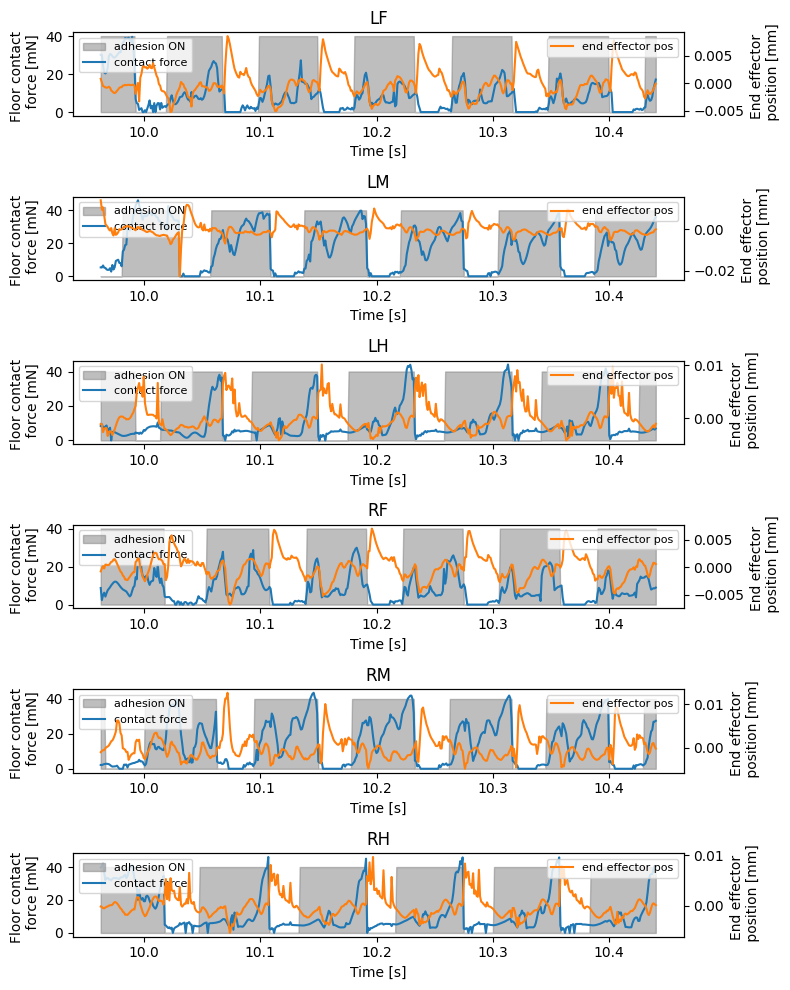

In [7]:
fig, axs = plt.subplots(len(end_effector_order), 1, figsize=(8, 10), tight_layout=True)
end_timestep_focus = int(start_timestep + (end_timestep - start_timestep)/3)

contact_forces = trial_data[0]["contact_force"][start_timestep:end_timestep_focus, :]
end_effector_pos = trial_data[0]["end_effector_pos"][start_timestep:end_timestep_focus, :]
adhesion = trial_data[0]["adhesion"][start_timestep:end_timestep_focus, :]

time = np.arange(start_timestep, end_timestep_focus)*timestep

for i, leg in enumerate(end_effector_order):
    axs[i].fill_between(time, adhesion[:, i]*40.0, 0, color="tab:gray", alpha=0.5, label="adhesion ON")
    axs[i].plot(time, contact_forces[:, i], label="contact force", color="tab:blue")
    
    twin_ax = axs[i].twinx()
    twin_ax.plot(time, end_effector_pos[:, i, 0], label="end effector pos", color="tab:orange")
    axs[i].set_title(f"{leg}")
    axs[i].set_xlabel("Time [s]")
    axs[i].set_ylabel("Floor contact \n force [mN]")
    twin_ax.set_ylabel("End effector \n position [mm]")
    axs[i].legend(loc="upper left", fontsize=8)
    twin_ax.legend(loc="upper right", fontsize=8)
plt.tight_layout

plt.show()

# Exercise 2: Build the model

During path navigation we would like to integrate the fly's heading and distance travelled throughout the simulation to obtain it's distance and orientation with respect to it's initial location.


In [A. Behbahani et al.](https://www.sciencedirect.com/science/article/pii/S0960982221011088?via%3Dihub) flies are proposed to perform odometry. Odometry is the use of data from motion sensors to estimate change in position over time. If you think of a cart with two driving wheels the difference of the number of revolutions between sides can bve used to track the orientation of the cart. By summing the number of revolutions on each side, we can get an estimate of the distance travelled by the cart. In the fly we propose that the amplitude of every step is directly related to the distance travelled by one side of the body and thus to the rotational and translational velocity of the fly. A step is composed of a swing (or return stroke) and a stance (or power stroke). We define the stride length as the distance between the anterior (toward the front) extreme position (AEP reached at the beginning of the stance) and the posterior (toward the back) extreme position (PEP reached at the end of the stance). Here is an illustration from [Yang et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10614758/).

<p align="center">
    <img src="source/stride_length_Yang2023.png" width="500" style="background-color: white;"/>
</p>

We propose a model where the fly would integrate the difference in left/right stride length $sl_L, sl_R$ and relate it to its orientation $o$ so that:

$ (1)$ $o[i] = b + k*\Delta sl[i]$  with  $\Delta sl[i] = \Sigma sl_L[i] - \Sigma sl_R[i]$,

$ (2) $ $\Sigma sl_L[i] = \sum_{i'=0}^{i} \sum_l^{left legs} x_l[i']*p_l[i']$

$ (3)$ $p_l[i] = c_l[i] < f_{thr}$

With $x_l$ one leg's end effector position along the x direction (direction of travel) and $p_l$ a binary time series that indicates wether the leg is in power stroke or not (contributes to propulsion or not).
There are multiple ways to obtain such a binary time serie. In our model we will rely on contact forces. Indeed just like in the cart example, the number of revolution should only be integrated when the wheel is not slipping. Similarly, we only want to accumulate the end effector position when the leg is in contact with the floor (and thus contributing to the fly's motion).
with $c_l$ the contact force of a leg and $f_{thr}$ the force threshold.

This whole models solely relies on the proprioceptive signals and contact forces, two quantities the fly has access to. While the difference in integrated stride length could be directly fitted to the orientation of the fly, it is simpler to consider a small time window and relate the difference in integrated stride length in this window with the change of orientation so that equation (1) becomes:

$\Delta o[i] = o[i] - o[i-w] = b + k*( \Delta sl[i] - \Delta sl[i-w] )$

Similarly we can estimate the distance travelled by the fly in a short time window:

$\Delta p[i] = p[i] - p[i-w] = b + k*( \Sigma sl[i] - \Sigma sl[i-w] )$ with $\Sigma sl[i] = \Sigma sl_L[i] + \Sigma sl_R[i]$


In [8]:
def extact_ground_thruth_variables(trial_data, time_scale, dt=1e-4):
    
    window_len = int(time_scale / dt)

    # Change in locomotion state (heading & displacement) ==========
    # Calculate change in fly orientation over proprioceptive time window (Δheading)
    fly_orientation_xy = trial_data["fly_orientation"]
    heading_ts = np.arctan2(fly_orientation_xy[:, 1], fly_orientation_xy[:, 0])
    heading_diff = heading_ts[window_len:] - heading_ts[:-window_len]
    heading_diff = (heading_diff + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]

    # Same for displacement projected in the direction of fly's heading
    # Use projection formula: proj_v(u) = (u · v) / (v · v) * v where v is the fly's
    # heading vector and u is the change in position
    fly_disp_xy = np.diff(trial_data["fly_pos"], axis=0, prepend=0)
    fly_orientation_xy_norm = np.linalg.norm(fly_orientation_xy, axis=1)
    fly_orientation_xy_unit = fly_orientation_xy / fly_orientation_xy_norm[:, None]
    udotv = np.sum(fly_disp_xy * fly_orientation_xy_unit, axis=1)
    vdotv = np.sum(fly_orientation_xy_unit * fly_orientation_xy_unit, axis=1)
    forward_disp_mag = udotv / vdotv
    forward_disp_total = np.cumsum(forward_disp_mag)
    forward_disp_total_diff = (
        forward_disp_total[window_len:] - forward_disp_total[:-window_len]
    )

    return heading_diff, forward_disp_total_diff

def extract_proprioceptive_variables(trial_data, time_scale, contact_force_thr, dt = 1e-4):
    window_len = int(time_scale / dt)

    # Proprioceptive signal ==========
    # Calculate total stride (Σstride) for each side
    ############################
    # TODO: Extract the stride length for each side 
    stride_left = trial_data["end_effector_pos"][:, :3, 0]
    stride_right = trial_data["end_effector_pos"][:, 3:, 0]
    ############################
    contact_mask = trial_data["contact_force"] > contact_force_thr  # (L, 6)
    
    ############################
    # TODO: Calculate the stride length for the stance period
    stride_left = (stride_left * contact_mask[:, :3]).sum(axis=1)
    stride_right = (stride_right * contact_mask[:, 3:]).sum(axis=1)
    ############################

    stride_total_left = np.cumsum(stride_left, axis=0)
    stride_total_right = np.cumsum(stride_right, axis=0)

    # Calculate difference in Σstride over proprioceptive time window (ΔΣstride)
    stride_total_diff_left = (
        stride_total_left[window_len:] - stride_total_left[:-window_len]
    )
    stride_total_diff_right = (
        stride_total_right[window_len:] - stride_total_right[:-window_len]
    )

    # Calculate sum and difference in ΔΣstride over two sides
    ############################
    # TODO: Calculate the final proprioceptive
    proprioceptive_distance_pred = stride_total_diff_left + stride_total_diff_right
    proprioceptive_heading_pred = stride_total_diff_left - stride_total_diff_right
    ############################

    return proprioceptive_heading_pred, proprioceptive_distance_pred

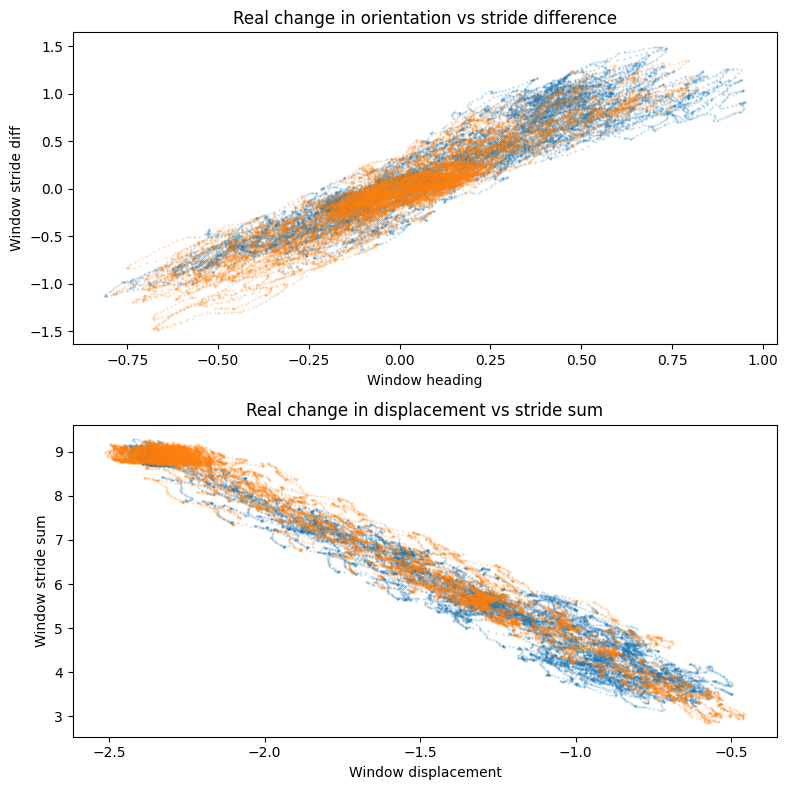

In [9]:
# The choice of hyperparameters is crucial for the performance of the model.
# A force threshold of 3.0 is 10% of the maximum force value, which is a reasonable value.
# The time scale of 0.64s spans more or less 6-7 steps, which is a reasonable time window to integrate long term changes in heading and not noise
ts = 0.64
f_thr = 3.0

delta_o0, delta_d0 = extact_ground_thruth_variables(trial_data[0], time_scale=ts, dt=timestep)
stride_length_difference0, stride_length_sum0 = extract_proprioceptive_variables(trial_data[0], time_scale=ts,
                                                                               contact_force_thr=f_thr, dt=timestep)
delta_o1, delta_d1 = extact_ground_thruth_variables(trial_data[1], time_scale=ts, dt=timestep)
stride_length_difference1, stride_length_sum1 = extract_proprioceptive_variables(trial_data[1], time_scale=ts,
                                                                               contact_force_thr=f_thr, dt=timestep)

fig, axs = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)
axs[0].scatter(stride_length_difference0, delta_o0, s=0.1, alpha=0.5)
axs[0].scatter(stride_length_difference1, delta_o1, s=0.1, alpha=0.5)
axs[0].set_xlabel("Window heading")
axs[0].set_ylabel("Window stride diff")
axs[0].set_title("Real change in orientation vs stride difference")

axs[1].scatter(stride_length_sum0, delta_d0 , s=0.1, alpha=0.5)
axs[1].scatter(stride_length_sum1, delta_d1 , s=0.1, alpha=0.5)
axs[1].set_xlabel("Window displacement")
axs[1].set_ylabel("Window stride sum")
axs[1].set_title("Real change in displacement vs stride sum")

plt.show()

As expected, the difference and sum in stride length correlates respectivelly with the heading and distance travelled by the fly. Let's build the linear model proposed in (1).

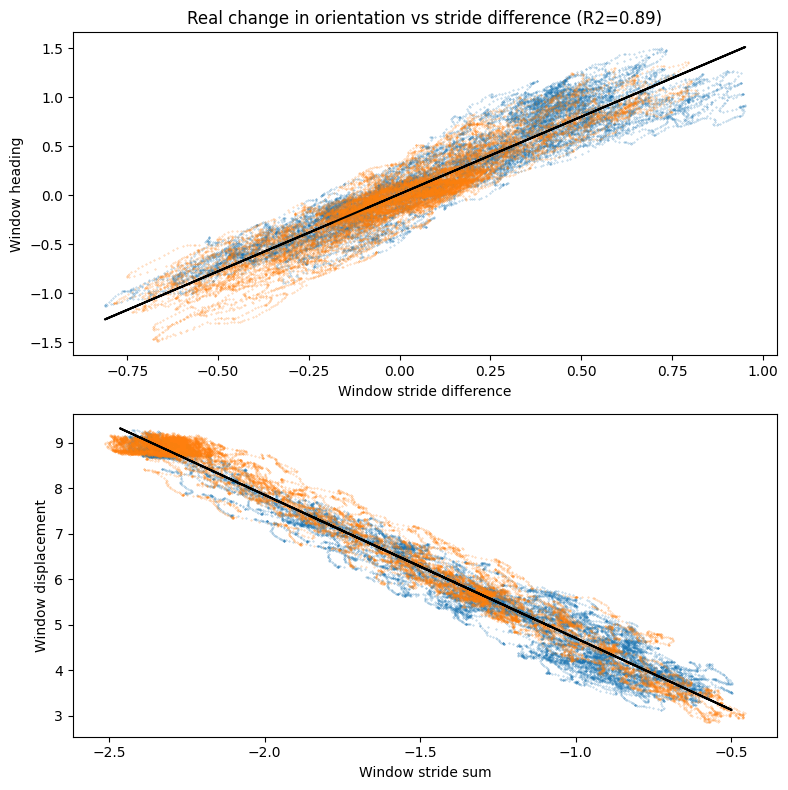

In [10]:
# fit a linear model to the proprioceptive data
def fit_1d_linear_model(x, y):
    k, b = np.polyfit(x, y, deg=1)
    model = np.poly1d([k, b])
    y_pred = model(x)
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return k, b, r2
k_prop_head, b_prop_head, r2_prop_head = fit_1d_linear_model(np.concatenate([stride_length_difference0, stride_length_difference1]),
                                                             np.concatenate([delta_o0, delta_o1]))
k_prop_disp, b_prop_disp, r2_prop_disp = fit_1d_linear_model(np.concatenate([stride_length_sum0, stride_length_sum1]),
                                                                np.concatenate([delta_d0, delta_d1]))

prop_heading_model = np.poly1d([k_prop_head, b_prop_head])
prop_disp_model = np.poly1d([k_prop_disp, b_prop_disp])

fig, axs = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)
axs[0].scatter(stride_length_difference0, delta_o0, s=0.1, alpha=0.5)
axs[0].scatter(stride_length_difference1, delta_o1, s=0.1, alpha=0.5)
axs[0].plot(stride_length_difference0, prop_heading_model(stride_length_difference0), color="black")
axs[0].set_xlabel("Window stride difference")
axs[0].set_ylabel("Window heading")
axs[0].set_title(f"Real change in orientation vs stride difference (R2={r2_prop_head:.2f})")

axs[1].scatter(stride_length_sum0, delta_d0, s=0.1, alpha=0.5)
axs[1].scatter(stride_length_sum1, delta_d1, s=0.1, alpha=0.5)
axs[1].plot(stride_length_sum0, prop_disp_model(stride_length_sum0), color="black")
axs[1].set_xlabel("Window stride sum")
axs[1].set_ylabel("Window displacement")

plt.show()

# Exercise 3: Perform path integration

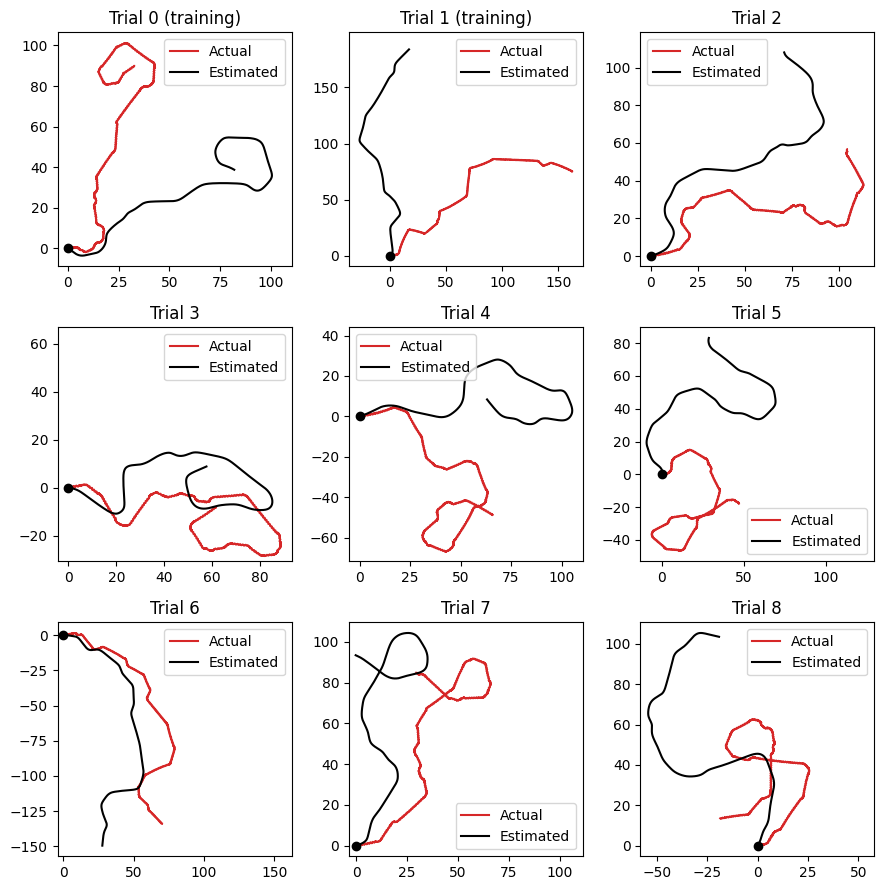

In [11]:
def path_integrate_prop(trial_data, heading_model, displacement_model, time_scale, dt):
    window_len = int(time_scale / dt)
    stride_length_difference, stride_length_sum = extract_proprioceptive_variables(
        trial_data,
        time_scale=ts,
        contact_force_thr=f_thr,
        dt=dt)

    # Integrate heading
    heading_diff_pred = heading_model(stride_length_difference)
    heading_pred = np.cumsum(heading_diff_pred / window_len)
    # Path int. not performed when not enough data is available. Start from the real
    # heading at the moment when path int. actually starts.
    hx_start, hy_start = trial_data["fly_orientation"][window_len, :]
    real_heading_start = np.arctan2(hy_start, hx_start)
    heading_pred += real_heading_start

    # Integrate displacement
    displacement_diff_pred = displacement_model(stride_length_sum)
    ############################
    # TODO: Project the change in displacement in the direction of the current heading
    displacement_diff_x_pred = np.cos(heading_pred) * displacement_diff_pred
    displacement_diff_y_pred = np.sin(heading_pred) * displacement_diff_pred
    ############################

    pos_x_pred = np.cumsum(displacement_diff_x_pred / window_len)
    pos_y_pred = np.cumsum(displacement_diff_y_pred / window_len)
    pos_pred = np.concatenate([pos_x_pred[:, None], pos_y_pred[:, None]], axis=1)

    # Pad with NaN where prediction not available
    heading_pred = np.concatenate([np.full(window_len, np.nan), heading_pred])
    pos_pred = np.concatenate([np.full((window_len, 2), np.nan), pos_pred], axis=0)

    return heading_pred, pos_pred

n_plots = len(trial_data) 
n_cols = 3
n_rows = n_plots // n_cols
plot_scale = 3.0

fig, axs = plt.subplots(n_rows, n_cols,
                        figsize = (plot_scale * n_cols, plot_scale * n_rows),
                        tight_layout=True)  

for i, td in enumerate(trial_data):
    heading_pred, pos_pred = path_integrate_prop(
        td,
        heading_model=prop_heading_model,
        displacement_model=prop_disp_model,
        time_scale=ts,
        dt=timestep,
    )
    pos_real = td["fly_pos"]
    ax = axs[i // n_cols, i % n_cols]
    ax.plot(pos_real[:, 0], pos_real[:, 1], color="tab:red", label="Actual")
    ax.plot(pos_pred[:, 0], pos_pred[:, 1], color="black", label="Estimated")
    ax.plot([0], [0], "o", color="black")
    if i < 2:
        ax.set_title(f"Trial {i} (training)")
    else:
        ax.set_title(f"Trial {i}")
    ax.axis('square')
    ax.set_aspect("equal")
    ax.legend()

# Exercise 4: Build a different model

With a simple regression we build an internal model that relates changes in proprioceptives variables to changes in orientation. As you can see, this model is not perfect and the estimated path sometimes deviates from the actual path. Does it necessary mean our model is completelly different then what the fly is doing ? Is our scenario ethologically realistic ? Name at least three cues the fly could rely on to perform more accurate paht integration.

In our model the fly relies on sensory signal to perform path integration. This approach might be robust to changes in the environment but might be more subject to sensors failures or noise. Are there other information the fly can rely on to perform path integration? In particular would it be possible to map the animals turning intention to the effective change in orientation? In the case of Neuromechfly, what would be the variable(s) you would use. Try to formalize this second model by taking inspiration from the following lines of code. Think about the differences or similarities this model will have with the one previously proposed.

ANSWER:
In most scenario, animals can rely on multiple cues to navigate an environement. Animals could rely on chemical cues (external odours, pheromones, ...), visual landmarks, celestial cues (Sun position extracted from the polarization of light), wind direction. 

When the fly is initiating a turn, it is sending a command to the motor center so that the turn is initiated. The fly could send a copy of those commands to path integrator and build an internal model mapping those intentions to the executed turn. In the case of Neuromechfly the turning intention is expressed in the "dn_drive".

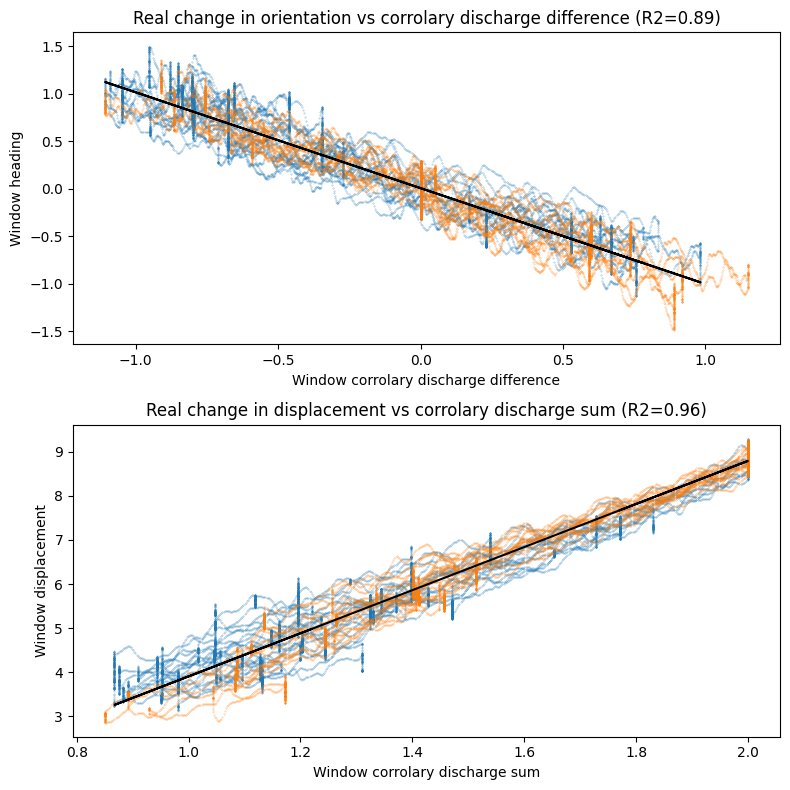

In [12]:
def extract_intention_variables(trial_data, time_scale, dt = 1e-4):

    window_len = int(time_scale / dt)

    ############################
    # TODO: Extract the intention of the animal and calculate its mean over the time window
    # Note that we are taking the mean here. This is because when a turn is initiated, the dn drive changes abrubtly.
    # The amount of turning in the window is dependant on the time since the initiation of the turn. 
    # THe mean will thus follow the continous change in the orientation depending on the exact timing of the initation of the turn.
    intention = trial_data["dn_drive"]
    conv_kernel = np.ones(window_len)[:, None] / window_len  # (window_len, 1)
    mean_dn_drive = convolve2d(intention, conv_kernel, mode="valid")[1:, :]
    ##############################

    # Same for left-right sum and difference
    sum_dn_drive = mean_dn_drive[:, 0] + mean_dn_drive[:, 1]
    diff_dn_drive = mean_dn_drive[:, 0] - mean_dn_drive[:, 1]

    return diff_dn_drive, sum_dn_drive

corr_discharge_diff0, corr_discharge_sum0 = extract_intention_variables(trial_data[0], time_scale=ts, dt=timestep)
corr_discharge_diff1, corr_discharge_sum1 = extract_intention_variables(trial_data[1], time_scale=ts, dt=timestep)

k_corr_diff, b_corr_diff, r2_corr_diff = fit_1d_linear_model(np.concatenate([corr_discharge_diff0, corr_discharge_diff1]),
                                                                np.concatenate([delta_o0, delta_o1]))
k_corr_sum, b_corr_sum, r2_corr_sum = fit_1d_linear_model(np.concatenate([corr_discharge_sum0, corr_discharge_sum1]),
                                                                np.concatenate([delta_d0, delta_d1]))

corr_heading_model = np.poly1d([k_corr_diff, b_corr_diff])
corr_disp_model = np.poly1d([k_corr_sum, b_corr_sum])

fig, axs = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)
axs[0].scatter(corr_discharge_diff0, delta_o0, s=0.1, alpha=0.5)
axs[0].scatter(corr_discharge_diff1, delta_o1, s=0.1, alpha=0.5)
axs[0].plot(corr_discharge_diff0, corr_heading_model(corr_discharge_diff0), color="black")
axs[0].set_xlabel("Window corrolary discharge difference")
axs[0].set_ylabel("Window heading")
axs[0].set_title(f"Real change in orientation vs corrolary discharge difference (R2={r2_corr_diff:.2f})")

axs[1].scatter(corr_discharge_sum0, delta_d0, s=0.1, alpha=0.5)
axs[1].scatter(corr_discharge_sum1, delta_d1, s=0.1, alpha=0.5)
axs[1].plot(corr_discharge_sum0, corr_disp_model(corr_discharge_sum0), color="black")
axs[1].set_xlabel("Window corrolary discharge sum")
axs[1].set_ylabel("Window displacement")
axs[1].set_title(f"Real change in displacement vs corrolary discharge sum (R2={r2_corr_sum:.2f})")

plt.show()


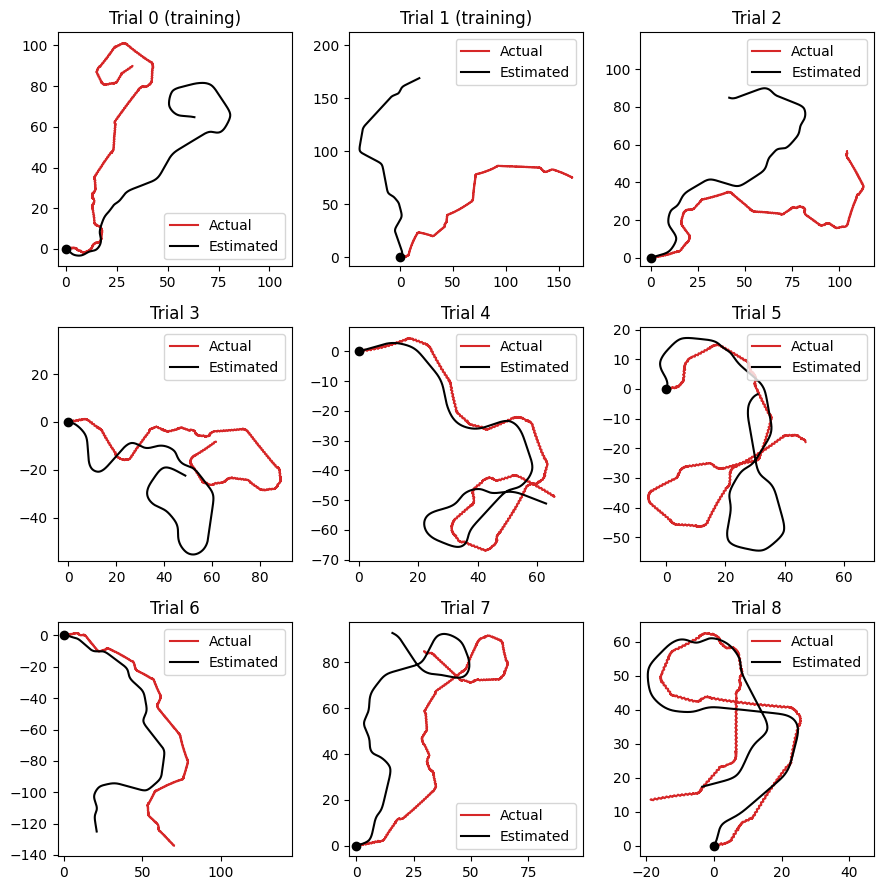

In [13]:
def path_integrate_corr(trial_data, heading_model, displacement_model, time_scale, dt):
    window_len = int(time_scale / dt)
    corr_discharge_diff, corr_discharge_sum = extract_intention_variables(
        trial_data,
        time_scale=ts,
        dt=dt)

    # Integrate heading
    heading_diff_pred = heading_model(corr_discharge_diff)
    heading_pred = np.cumsum(heading_diff_pred / window_len)
    # Path int. not performed when not enough data is available. Start from the real
    # heading at the moment when path int. actually starts.
    hx_start, hy_start = trial_data["fly_orientation"][window_len, :]
    real_heading_start = np.arctan2(hy_start, hx_start)
    heading_pred += real_heading_start

    # Integrate displacement
    displacement_diff_pred = displacement_model(corr_discharge_sum)
    ############################
    # TODO: Project the change in displacement in the direction of the current heading
    displacement_diff_x_pred = np.cos(heading_pred) * displacement_diff_pred
    displacement_diff_y_pred = np.sin(heading_pred) * displacement_diff_pred
    ############################

    pos_x_pred = np.cumsum(displacement_diff_x_pred / window_len)
    pos_y_pred = np.cumsum(displacement_diff_y_pred / window_len)
    pos_pred = np.concatenate([pos_x_pred[:, None], pos_y_pred[:, None]], axis=1)

    # Pad with NaN where prediction not available
    heading_pred = np.concatenate([np.full(window_len, np.nan), heading_pred])
    pos_pred = np.concatenate([np.full((window_len, 2), np.nan), pos_pred], axis=0)

    return heading_pred, pos_pred

n_plots = len(trial_data) 
n_cols = 3
n_rows = n_plots // n_cols
plot_scale = 3.0

fig, axs = plt.subplots(n_rows, n_cols,
                        figsize = (plot_scale * n_cols, plot_scale * n_rows),
                        tight_layout=True)  

for i, td in enumerate(trial_data):
    heading_pred, pos_pred = path_integrate_corr(
        td,
        heading_model=corr_heading_model,
        displacement_model=corr_disp_model,
        time_scale=ts,
        dt=timestep,
    )
    pos_real = td["fly_pos"]
    ax = axs[i // n_cols, i % n_cols]
    ax.plot(pos_real[:, 0], pos_real[:, 1], color="tab:red", label="Actual")
    ax.plot(pos_pred[:, 0], pos_pred[:, 1], color="black", label="Estimated")
    ax.plot([0], [0], "o", color="black")
    if i < 2:
        ax.set_title(f"Trial {i} (training)")
    else:
        ax.set_title(f"Trial {i}")
    ax.axis('square')
    ax.set_aspect("equal")
    ax.legend()